# Sesi 14 - Deep Dive LSTM
This dataset is a playground for fundamental and technical analysis. It is said that 30% of traffic on stocks is already generated by machines, can trading be fully automated? If not, there is still a lot to learn from historical data.

Link Dataset
https://www.kaggle.com/datasets/dgawlik/nyse/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_stock = pd.read_csv('/content/drive/MyDrive/Indonesia AI DataSet/prices-split-adjusted.csv')
df_stock

Mounted at /content/drive


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


In [ ]:
# Unique symbols count
print('Unique symbols count:', df_stock['symbol'].nunique())

Unique symbols count: 501


In [ ]:
df_stock['symbol'].value_counts().head(10)

,count
symbol,
KSU,1762
NOC,1762
ORCL,1762
OMC,1762
OKE,1762
O,1762
NWL,1762
NVDA,1762
NUE,1762


In [ ]:
# Split only WLTW stock
df_stock = df_stock[df_stock.symbol == 'NOC']

df_stock

,date,symbol,open,close,low,high,volume
559,2010-01-04,NOC,50.686495,51.364120,50.686495,51.382190,1616100.0
1027,2010-01-05,NOC,51.228595,51.454471,51.228595,51.906220,1859800.0
1495,2010-01-06,NOC,51.318946,51.653240,51.129210,51.698415,2204900.0
1963,2010-01-07,NOC,51.427364,52.186308,51.246665,52.367006,4750900.0
2431,2010-01-08,NOC,51.833940,51.897187,51.635170,52.493498,1723700.0
...,...,...,...,...,...,...,...
849093,2016-12-23,NOC,231.470001,232.990005,231.240005,234.369995,852100.0
849593,2016-12-27,NOC,233.970001,233.240005,232.330002,234.350006,479400.0
850093,2016-12-28,NOC,233.240005,231.949997,231.559998,233.679993,493200.0
850593,2016-12-29,NOC,232.229996,232.630005,232.100006,233.820007,538500.0


In [ ]:
# Export to csv
df_stock.to_csv('NOC.csv', index=False)

# Prepare Data

In [ ]:
# Ambil data KSU.csv
df_stock = pd.read_csv("NOC.csv")
plot_x = df_stock['date'].copy()
df_stock.set_index("date", inplace = True)
df_stock.index = pd.to_datetime(df_stock.index)
df_stock.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,NOC,50.686495,51.364120,50.686495,51.382190,1616100.0
2010-01-05,NOC,51.228595,51.454471,51.228595,51.906220,1859800.0
2010-01-06,NOC,51.318946,51.653240,51.129210,51.698415,2204900.0
2010-01-07,NOC,51.427364,52.186308,51.246665,52.367006,4750900.0
2010-01-08,NOC,51.833940,51.897187,51.635170,52.493498,1723700.0


Text(0, 0.5, 'volume')

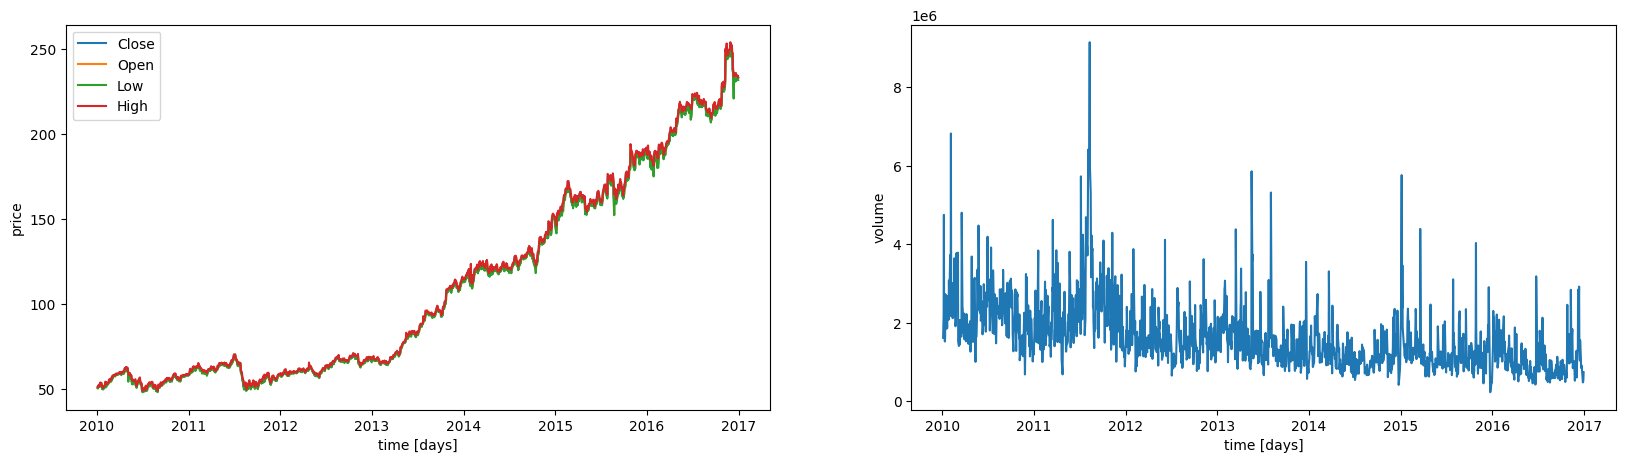

In [ ]:
# Plot data KSU
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(df_stock['close'])
ax[0].plot(df_stock['open'])
ax[0].plot(df_stock['low'])
ax[0].plot(df_stock['high'])
ax[0].legend(['Close', 'Open', 'Low', 'High'], loc='best')
ax[0].set_xlabel('time [days]')
ax[0].set_ylabel('price')

ax[1].plot(df_stock['volume'])
ax[1].set_xlabel('time [days]')
ax[1].set_ylabel('volume')


# Preprocessing Data

In [ ]:
# Split data
# Scalling

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
df_stock.drop(['symbol'], axis=1, inplace=True)
x = df_stock[['open', 'low', 'high', 'volume']].copy()
y = df_stock['close'].copy()

x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])

    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]

    x_test = data[train_split:, :-1]
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 22
x['close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1565, 22, 5) (1565,) (174, 22, 5) (174,)


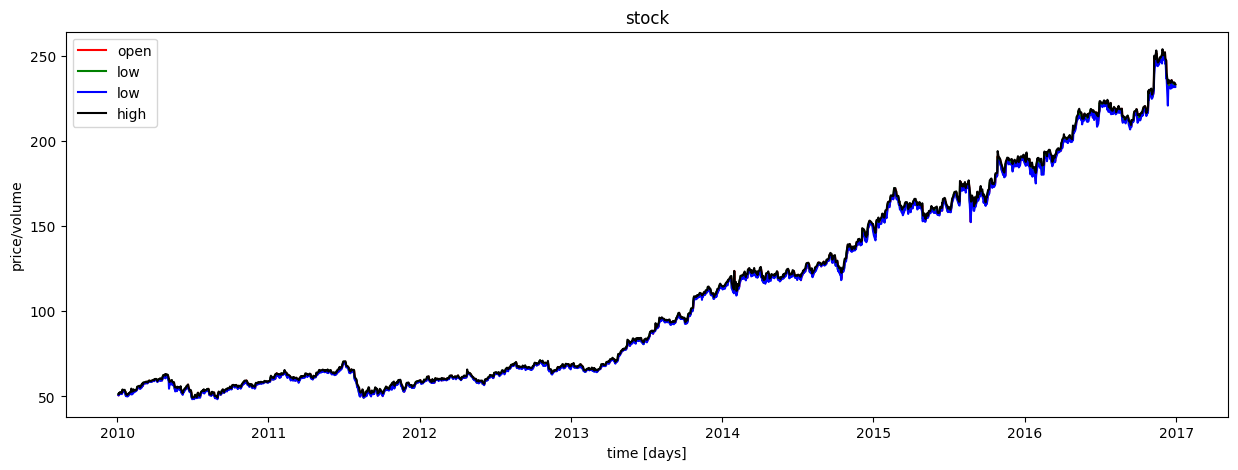

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock['open'], color='red', label='open')
plt.plot(df_stock['close'], color='green', label='low')
plt.plot(df_stock['low'], color='blue', label='low')
plt.plot(df_stock['high'], color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('price/volume')
plt.legend(loc='best')
plt.show()

# Model 1 - Single LSTM Using Dropout

In [ ]:
#LSTM architecture
model1 = Sequential()
# First LSTM layer with Dropout regularisation
model1.add(LSTM(units=50, input_shape=(window,5)))
model1.add(Dropout(0.2))

# The output layer
model1.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model1.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))


# Compiling the RNN
model1.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history1=model1.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1)
print ('compilation time : ', time.time() - start)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0501 - val_loss: 5.3754e-04
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8285e-04 - val_loss: 0.0018
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.8065e-04 - val_loss: 0.0011
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.3112e-04 - val_loss: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4245e-04 - val_loss: 0.0017
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0831e-04 - val_loss: 5.2241e-04
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5267e-04 - val_loss: 3.7625e-04
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4347e-04 - val_loss: 0.0022
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3627e-04 - val_loss: 0.0020
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5100e-04 - val_loss: 0.0016
Epoc

<Axes: >

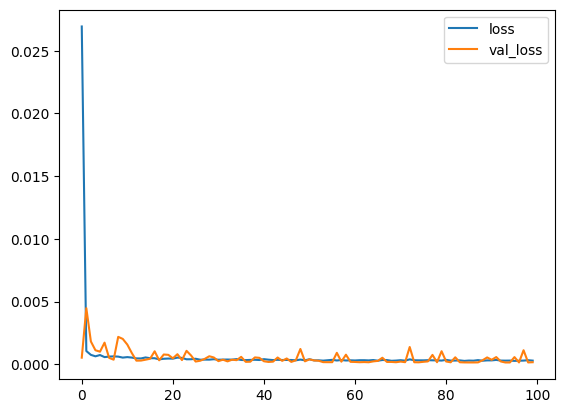

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history1.history)
losses.plot()

In [ ]:
trainPredict = model1.predict(X_train)
testPredict = model1.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(174, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(174, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(174, 1)
(174, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.90 RMSE
Test Score: 3.34 RMSE


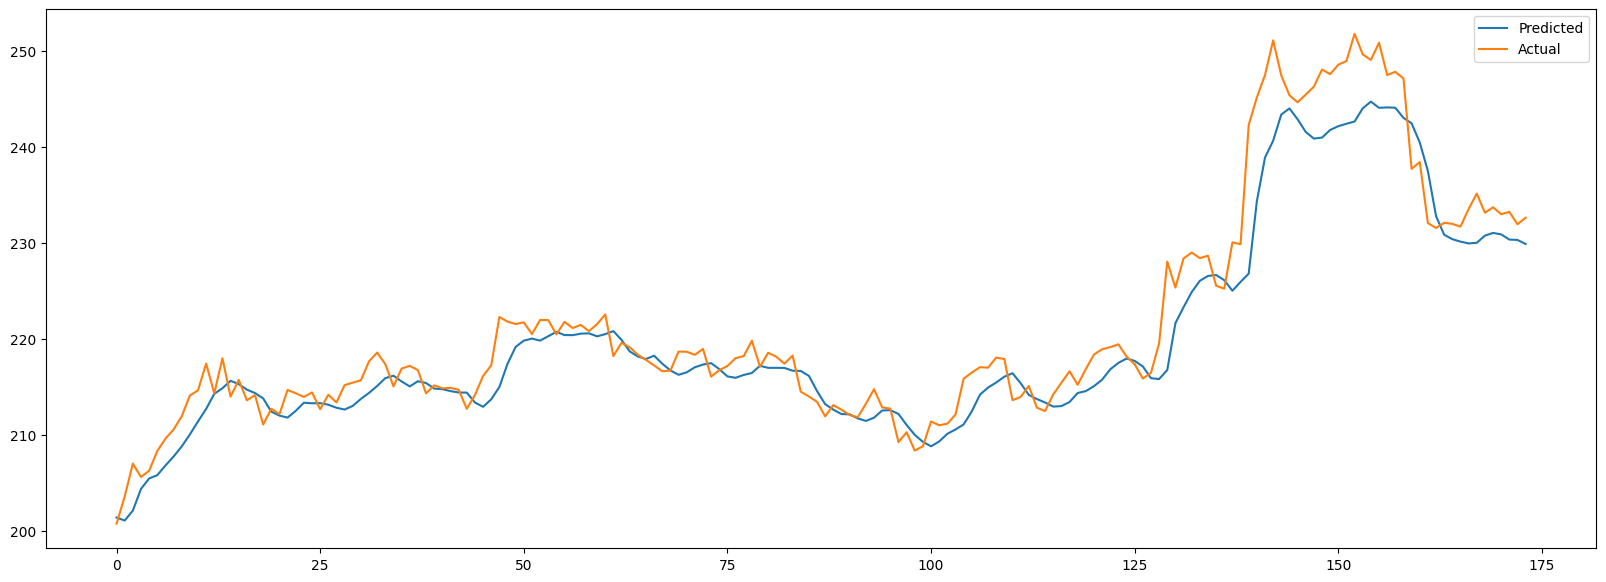

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

# Model 2 - Stack LSTM using Dropout

In [ ]:
#LSTM architecture
model2 = Sequential()
# First LSTM layer with Dropout regularisation
model2.add(LSTM(units=50, input_shape=(window,5),return_sequences=True))
model2.add(Dropout(0.2))
# Second LSTM layer
model2.add(LSTM(units=50))
model2.add(Dropout(0.2))

# The output layer
model2.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history2=model2.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0434 - val_loss: 0.0030
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.2651e-04 - val_loss: 0.0022
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.2993e-04 - val_loss: 9.9862e-04
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.3587e-04 - val_loss: 0.0012
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.7321e-04 - val_loss: 0.0013
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.3498e-04 - val_loss: 0.0025
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 7.3109e-04 - val_loss: 0.0024
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.0365e-04 - val_loss: 9.6386e-04
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.6225e-04 - val_loss: 6.8683e-04
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.5679e-04 - val_loss: 0.0011
Epoc

<Axes: >

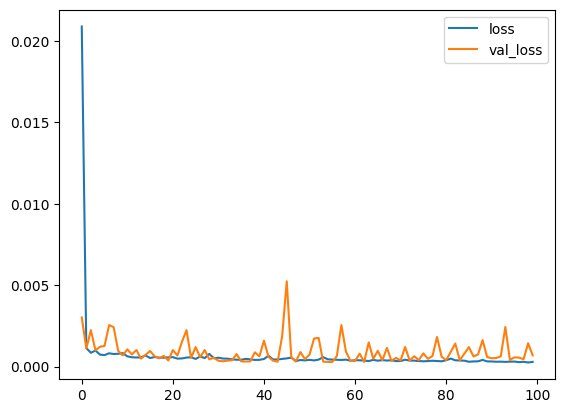

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history2.history)
losses.plot()

In [ ]:
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(174, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(174, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
(174, 1)
(174, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.42 RMSE
Test Score: 22.53 RMSE


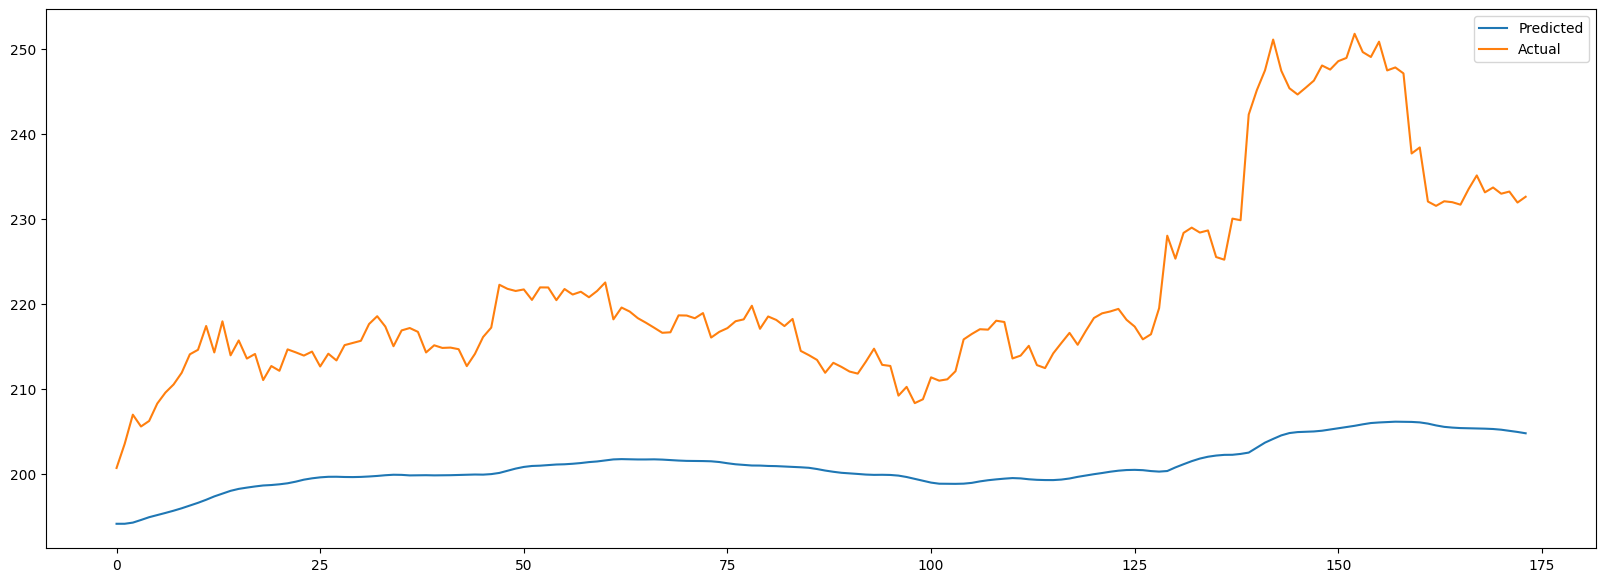

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [ ]:
pd.DataFrame(plot_predicted).describe()

,0
count,174.000000
mean,200.912491
std,2.690077
min,194.166885
25%,199.520329
50%,200.405960
75%,201.744015
max,206.174927


# Model 3 - Bidirectional LSTM

In [ ]:
# Stack LSTM architecture
model3 = Sequential()
# Bidirectional LSTM layer with Dropout regularisation
model3.add(Bidirectional(LSTM(units=50), input_shape=(window,5)))
model3.add(Dropout(0.2))
# The output layer
model3.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model3.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model3.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history3=model3.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0468 - val_loss: 0.0037
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5274e-04 - val_loss: 0.0017
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.4346e-04 - val_loss: 6.6236e-04
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.6524e-04 - val_loss: 4.5794e-04
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.0021e-04 - val_loss: 4.4420e-04
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.4146e-04 - val_loss: 4.8203e-04
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.0285e-04 - val_loss: 9.9682e-04
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.9547e-04 - val_loss: 4.2510e-04
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.8816e-04 - val_loss: 0.0030
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.3923e-04 - val_loss: 3.8524e-04
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9591e-04 - val_loss: 4.5

<Axes: >

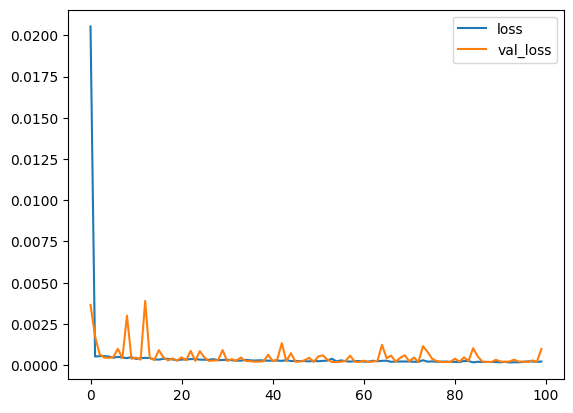

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history3.history)
losses.plot()

In [ ]:
trainPredict = model3.predict(X_train)
testPredict = model3.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(174, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(174, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(174, 1)
(174, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 14.52 RMSE


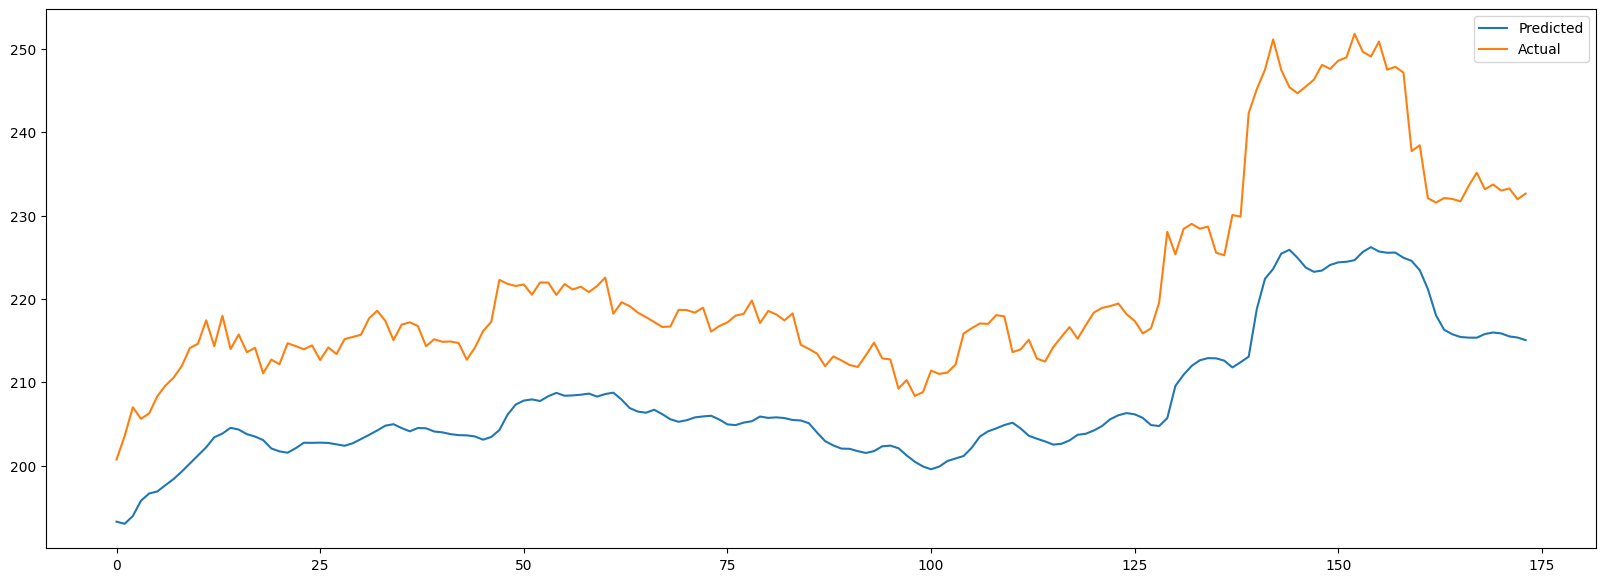

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

# Model 4 - GRU

In [ ]:
# Stack LSTM architecture
model4 = Sequential()
# GRU layer with Dropout regularisation
model4.add(GRU(units=50, input_shape=(window,5)))
model4.add(Dropout(0.2))

# The output layer
model4.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model4.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model4.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history4=model4.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0470 - val_loss: 0.0054
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.7794e-04 - val_loss: 7.4456e-04
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3369e-04 - val_loss: 2.6615e-04
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.1081e-04 - val_loss: 8.1821e-04
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.2153e-04 - val_loss: 5.8045e-04
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0758e-04 - val_loss: 2.7041e-04
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.3448e-04 - val_loss: 2.1014e-04
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.0707e-04 - val_loss: 1.9314e-04
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.7736e-04 - val_loss: 2.3709e-04
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.2348e-04 - val_loss: 7.9

<Axes: >

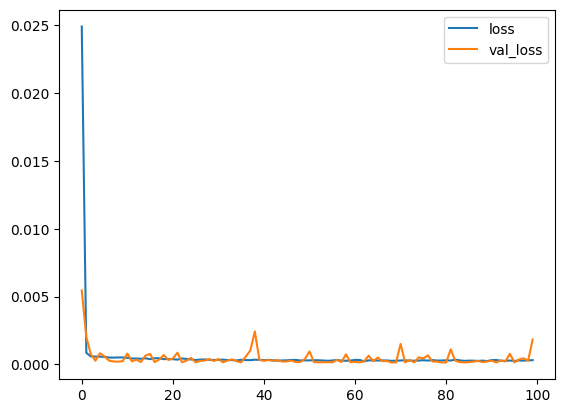

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history4.history)
losses.plot()

In [ ]:
trainPredict = model4.predict(X_train)
testPredict = model4.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(174, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(174, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
(174, 1)
(174, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.41 RMSE
Test Score: 16.29 RMSE


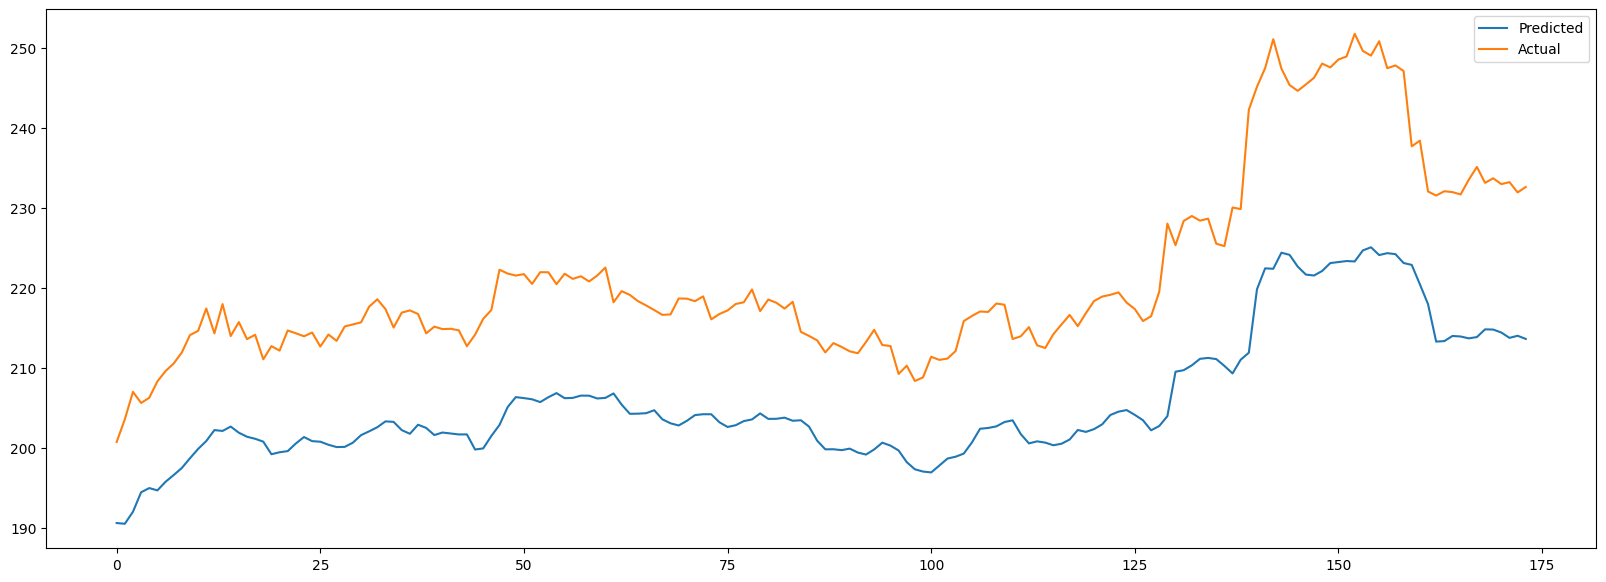

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

# Model 5 - LSTM using BatchNormalization and Regularization L1 & L2

In [ ]:
# LSTM using BatchNormalization and Regularization (L1 and L2)
#LSTM architecture
model5 = Sequential()
# First LSTM layer with Dropout regularisation
model5.add(LSTM(units=50, input_shape=(window,5),kernel_regularizer='l2'))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))

# The output layer
model5.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model5.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))


# Compiling the RNN
model5.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history5=model5.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1)
print ('compilation time : ', time.time() - start)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1333 - val_loss: 0.3410
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0440 - val_loss: 0.2140
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0184 - val_loss: 0.2067
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0094 - val_loss: 0.1991
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 0.2000
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - val_loss: 0.1880
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - val_loss: 0.1767
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 0.1533
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.1427
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 0.1316
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.1045
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

<Axes: >

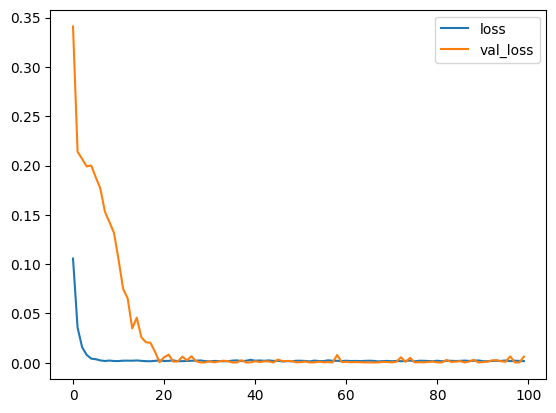

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history5.history)
losses.plot()

In [ ]:
trainPredict = model5.predict(X_train)
testPredict = model5.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(174, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(174, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
(174, 1)
(174, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.97 RMSE
Test Score: 21.24 RMSE


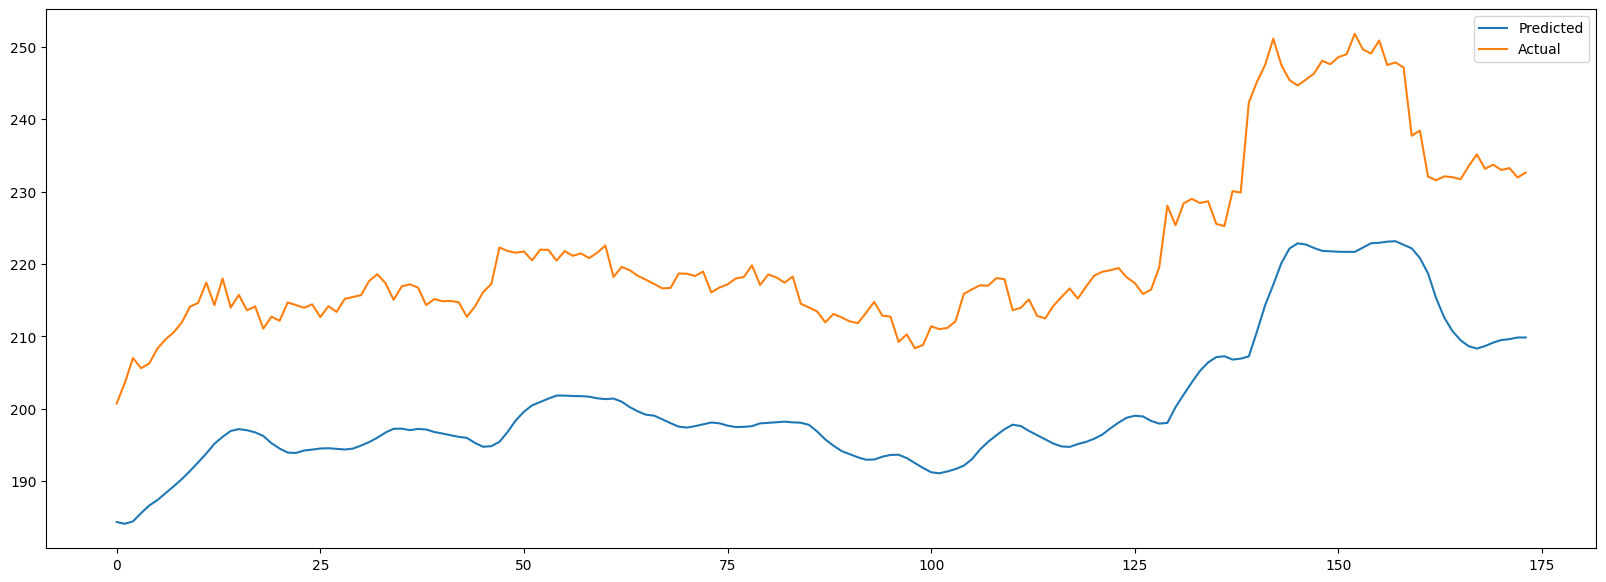

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

# Perbandingan Model

In [ ]:
model = [model1, model2, model3, model4, model5]
history = [history1, history2, history3, history4, history5]
trainScore = []
testScore = []

for i in range(5):
    trainPredict = model[i].predict(X_train)
    testPredict = model[i].predict(X_test)

    trainPredict = y_scaler.inverse_transform(trainPredict)
    trainY = y_scaler.inverse_transform([y_train])
    testPredict = y_scaler.inverse_transform(testPredict)
    testY = y_scaler.inverse_transform([y_test])

    trainScore.append(mean_squared_error(trainY[0], trainPredict[:,0]) ** .5)
    testScore.append(mean_squared_error(testY[0], testPredict[:,0]) ** .5)

    print('Model', i+1)
    print('Train Score: %.2f RMSE' % (trainScore[i]))
    print('Test Score: %.2f RMSE' % (testScore[i]))
    print('\n')


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model 1
Train Score: 1.90 RMSE
Test Score: 3.34 RMSE


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Model 2
Train Score: 2.42 RMSE
Test Score: 22.53 RMSE


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Model 3
Train Score: 2.63 RMSE
Test Score: 14.52 RMSE


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model 4
Train Score: 3.41 RMSE
Test Score: 16.29 RMSE


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model 5
Train Score: 7.97 RMSE
Test Score: 21.24 RMSE




In [ ]:
# Make trainscore and testscore to dataframe
name_of_model = ['LSTM', 'Stacked LSTM', 'Bidirectional LSTM', 'GRU', 'LSTM with BatchNormalization and Regularization']
df_score = pd.DataFrame({'Model':name_of_model,'Train Score': trainScore, 'Test Score': testScore})
df_score

,Model,Train Score,Test Score
0,LSTM,1.900388,3.344869
1,Stacked LSTM,2.417218,22.534442
2,Bidirectional LSTM,2.630052,14.522980
3,GRU,3.413643,16.286370
4,LSTM with BatchNormalization and Regularization,7.974382,21.241054


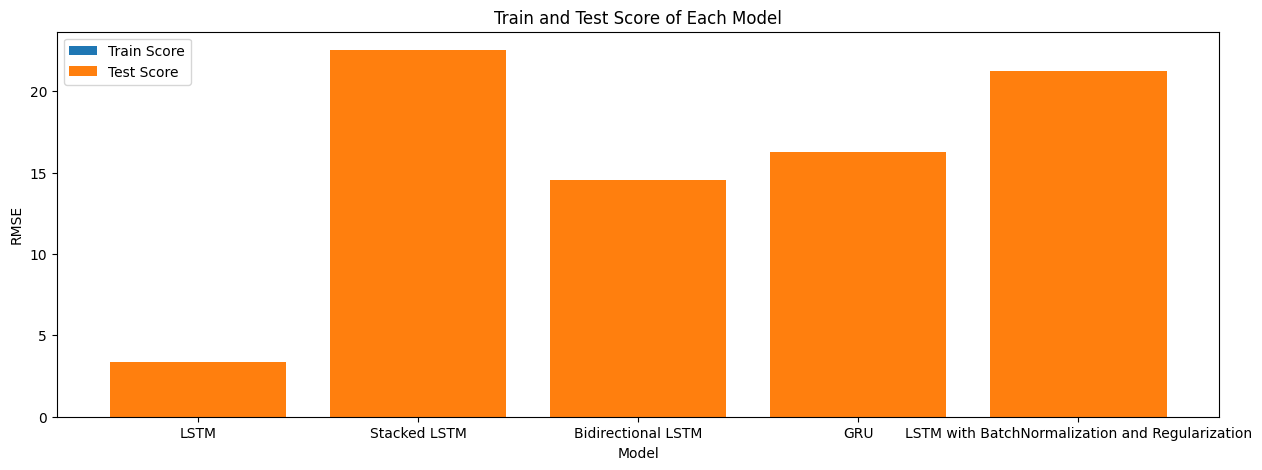

In [ ]:
# Plot the result with bar chart
plt.figure(figsize=(15, 5))
plt.bar(df_score['Model'], df_score['Train Score'], label='Train Score')
plt.bar(df_score['Model'], df_score['Test Score'], label='Test Score')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Train and Test Score of Each Model')
plt.legend(loc='best')
plt.show()

In [ ]:
model4.save('./Final_model.h5')

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time
import numpy as np

# Set up TimeSeriesSplit (number of folds)
n_splits = 5  # You can adjust the number of splits/folds
tscv = TimeSeriesSplit(n_splits=n_splits)

# List to store the validation losses for each fold
val_losses = []

# Start cross-validation
for train_index, val_index in tscv.split(X_train):
    # Split data into training and validation based on the fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define model for each fold
    model2 = Sequential()
    model2.add(LSTM(units=50, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]), return_sequences=True))
    model2.add(Dropout(0.2))
    model2.add(LSTM(units=50))
    model2.add(Dropout(0.2))
    model2.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
    model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

    # Early stopping to prevent overfitting
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    callbacks_list = [earlystop]

    # Compile the model
    model2.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training fold data
    start = time.time()
    history2 = model2.fit(X_train_fold, y_train_fold, epochs=100, batch_size=35, validation_data=(X_val_fold, y_val_fold),
                          verbose=1, callbacks=callbacks_list)

    print(f"Fold training time: {time.time() - start}")

    # Store the validation loss for each fold
    val_losses.append(history2.history['val_loss'][-1])

# Calculate the average validation loss across all folds
avg_val_loss = np.mean(val_losses)
print(f"Average validation loss across all folds: {avg_val_loss}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0013 - val_loss: 5.8691e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.0497e-04 - val_loss: 8.3191e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.5954e-04 - val_loss: 7.1827e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.1744e-04 - val_loss: 4.4882e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.9589e-04 - val_loss: 5.1907e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.5174e-04 - val_loss: 2.1944e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.4282e-04 - val_loss: 1.3895e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.3009e-04 - val_loss: 1.2738e-04
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0911e-04 - val_loss: 1.7005e-04
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1490e-04 - val_loss: 1.4729e-04
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1996e-04 - val_loss: 1.0884e-04
E

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit

# Set up TimeSeriesSplit (number of folds)
n_splits = 5  # You can adjust the number of splits/folds
tscv = TimeSeriesSplit(n_splits=n_splits)

# List to store the validation losses for each fold and RMSE values
val_losses = []
train_rmse_values = []
val_rmse_values = []

# Start cross-validation
for train_index, val_index in tscv.split(X_train):
    # Split data into training and validation based on the fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define model for each fold
    model2 = Sequential()
    model2.add(LSTM(units=50, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]), return_sequences=True))
    model2.add(Dropout(0.2))
    model2.add(LSTM(units=50))
    model2.add(Dropout(0.2))
    model2.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
    model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

    # Early stopping to prevent overfitting
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    callbacks_list = [earlystop]

    # Compile the model
    model2.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training fold data
    start = time.time()
    history2 = model2.fit(X_train_fold, y_train_fold, epochs=100, batch_size=35, validation_data=(X_val_fold, y_val_fold),
                          verbose=1, callbacks=callbacks_list)

    print(f"Fold training time: {time.time() - start}")

    # Store the validation loss for each fold
    val_losses.append(history2.history['val_loss'][-1])

    # Predict on the train and validation data
    train_preds = model2.predict(X_train_fold)
    val_preds = model2.predict(X_val_fold)

    # Calculate RMSE for train and validation sets
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))

    # Store RMSE values
    train_rmse_values.append(train_rmse)
    val_rmse_values.append(val_rmse)

# Calculate the average validation loss and RMSE across all folds
avg_val_loss = np.mean(val_losses)
avg_train_rmse = np.mean(train_rmse_values)
avg_val_rmse = np.mean(val_rmse_values)

print(f"Average validation loss across all folds: {avg_val_loss}")
print(f"Average RMSE on train data across all folds: {avg_train_rmse}")
print(f"Average RMSE on validation data across all folds: {avg_val_rmse}")